In [1]:
import sys
sys.path.insert(1, '../')
from torchvision.datasets import MNIST
from autograd import tensor
from autograd import modules
from autograd.dataloader import DataLoader
from autograd.losses import CrossEntropyLoss, MSELoss
import logging
import logging_settings
import numpy as np

In [4]:
mnist_trainset = MNIST(root='./data', train=False,download=True,transform=None)
mnist_testset = MNIST(root='./data', train=False, download=True, transform=None)

In [5]:
class MNISTDataset:
    def __init__(self, mnist):
        self.mnist = mnist
    def __len__(self):
        return len(self.mnist)
    def __getitem__(self, idx):
        pil_image, label = self.mnist[idx]
        label_onehot = np.zeros(10,dtype='float64')
        label_onehot[label] = 1
        return np.asarray(pil_image).astype('float64') / 255, label_onehot

In [6]:
train_dataset = MNISTDataset(mnist_trainset)
test_dataset = MNISTDataset(mnist_testset)
train_dataloader = DataLoader(train_dataset)
test_dataloader = DataLoader(test_dataset)

In [40]:
model = modules.Sequential(
    [
        modules.Flatten(),
        modules.Linear(784, 250),
        modules.ReLU(),
        modules.Linear(250, 10),
        modules.Softmax()
    ]
)

In [41]:
loss_function = CrossEntropyLoss()
lr = 0.01
loss_log = {'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': []}

In [42]:
for epoch in range(100):
    train_loss, test_loss = 0, 0
    train_ncorrect, test_ncorrect = 0,0
    print(f"Epoch {epoch+1}")
    for x, y in train_dataloader:
        yhat = model(tensor.tensor(x))
        loss = loss_function(yhat, tensor.tensor(y))
        train_loss += loss.item() * len(y)

        train_ncorrect += (yhat.asarray().argmax(axis=-1) == y.argmax(axis=-1)).sum()
        loss.backward()
        for parameter in model.parameters():
            parameter -= lr * parameter.grad
    train_loss /= len(train_dataloader.dataset)

    for x, y in test_dataloader:
        yhat = model(x)
        loss = loss_function(yhat, y)
        test_loss += loss.item() * len(y)
        loss.clear_graph()
        test_ncorrect += (yhat.asarray().argmax(axis=-1) == y.argmax(axis=-1)).sum()
        
    test_loss /= len(test_dataloader.dataset)
    loss_log['train_loss'].append(train_loss)
    loss_log['test_loss'].append(test_loss)
    loss_log['train_accuracy'].append(train_ncorrect / len(train_dataloader.dataset))
    loss_log['test_accuracy'].append(test_ncorrect / len(test_dataloader.dataset))

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100


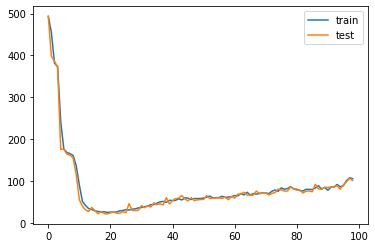

In [43]:
import matplotlib.pyplot as plt
plt.plot(loss_log['train_loss'][1:], label='train')
plt.plot(loss_log['test_loss'][1:], label='test')
plt.legend()

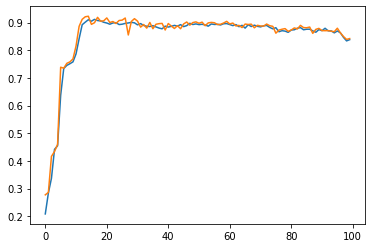

In [44]:
import matplotlib.pyplot as plt
plt.plot(loss_log['train_accuracy'], label='train')
plt.plot(loss_log['test_accuracy'], label='test')